# Calibration of Orbitrap deltas
Removes blank injections, identifies samples and standards, runs an ensemble of linear calibrations peturbed by SEM values of data and uncertainties of reference values

## Input:
- 'Result_YYYY_MM_DD.csv' file for the sequence, produced by Thermo R script
- Nitrate reference data 'nitrate_references.xlsx'

## Output:
1. Calibration curves and uncertainties for each isotopologue
2. Calibrated delta values for each sample

In [95]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Specify the path to csv results file
folder = '240208_CdD_202-215_M0'
file = 'results_2024-02-08.csv'

isotopologs = ['15N', '17O','18O']

### Load results csv file and seperate samples from standards by name

In [96]:
# create calibrations folder
directory_path = os.path.join(folder,'calibration')
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")
else:
    print(f"Directory '{directory_path}' already exists.")

# load results csv
df1 = pd.read_csv(os.path.join(folder,file))
print('Loaded results file ' + file )

# new df for sorted results
df = pd.DataFrame(columns=list(df1.columns[[1,2,3,4,5,6,11]])+['d'+iso for iso in isotopologs])
df[df1.columns[[1,2,3,4,5,6,11]]] = df1[df1['isotopolog']==isotopologs[0]].reset_index()[df1.columns[[1,2,3,4,5,6,11]]]
for iso in isotopologs:
    df['d'+iso] = df1[df1['isotopolog']==iso].reset_index()['Delta_Value_vs_Reference_Material']
    
# remove injections where name stars with Blank
df = df[~df['sample.name'].str.startswith('Blank')].dropna()

# seperate standards and samples
stds_df = df[df['sample.name'].str.startswith(('NICO','USGS')) ]
samples_df = df[df['sample.name'].str.startswith(('CdD', 'CDD','ech')) ].sort_values(by='sample.name')

# function to average repeat injections of same sample
def summarise(df):

    isotopologs=['d15N','d17O','d18O']
    means=['mean_d15N','mean_d17O','mean_d18O']
    sems=['err_d15N','err_d17O','err_d18O']

    stats=pd.DataFrame()
    stats['sample.name']=df.groupby('sample.name')[isotopologs].mean().reset_index()['sample.name']
    stats[means]=df.groupby('sample.name')[isotopologs].mean().reset_index()[isotopologs]
    stats[sems]=df.groupby('sample.name')[isotopologs].sem().reset_index()[isotopologs]
    
    return stats.sort_values(by='sample.name')

# Contain mean and sem deltas of each sample
stds_stats = summarise(stds_df)
samples_stats = summarise(samples_df)

Directory '240208_CdD_202-215_M0/calibration' created.
Loaded results file results_2024-02-08.csv


### Identification of standards
1. Verify ratios of non-dried standard are correct.
2. Rename as 'USGS34', 'NICO6' etc using the dictionary 'nn'.

In [97]:
stds_stats.head()

,sample.name,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
0,NICO6-1,34.455697,17.406028,32.945567,0.323208,0.605002,0.429581
1,USGS34 non seche,-1.820055,-16.393482,-27.974231,0.396142,0.819384,0.434033
2,USGS34-1 seche,-1.332438,-14.787331,-27.052681,0.381358,0.809747,0.253200
3,USGS35-1 seche,3.340414,51.939431,58.983114,0.469186,0.799706,0.296659


In [98]:
nn = { 'NICO6-1':'NICO6', 'USGS34-1 seche':'USGS34', 'USGS35-1 seche':'USGS35' }

# Rename as per nn
for oldname, newname in nn.items():
    for i, name in enumerate(stds_stats['sample.name']):
        if name == oldname:
            stds_stats.loc[i,'sample.name'] = newname

# Remove all other rows
for i, name in enumerate(stds_stats['sample.name']):
    if name not in nn.values():
        stds_stats = stds_stats.drop(index=i)
        stds_stats.reset_index(inplace=True)

stds_stats.head()

,index,sample.name,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
0,0,NICO6,34.455697,17.406028,32.945567,0.323208,0.605002,0.429581
1,2,USGS34,-1.332438,-14.787331,-27.052681,0.381358,0.809747,0.253200
2,3,USGS35,3.340414,51.939431,58.983114,0.469186,0.799706,0.296659


### Identification of samples
Rename Col du Dôme samples as 'CDD-202' etc 

In [99]:
samples_stats.head()

,sample.name,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
0,ech 202,-1.733723,62.109951,71.691949,0.450395,0.814377,0.106012
1,ech 203,-2.075807,54.040041,62.367272,0.570223,0.759231,0.373507
2,ech 204,-1.718172,50.778189,59.593885,0.482539,1.285712,0.131038
3,ech 205,-1.505119,58.610673,67.318092,0.357255,1.173726,0.301249
4,ech 206,1.109723,64.375515,73.715508,0.351757,0.387211,0.152771


In [100]:
oldnames = samples_stats['sample.name']
newnames = ['CDD-' + n.split(' ')[-1] for n in oldnames if n.startswith('ech')]
nn = dict(zip(oldnames, newnames))

# Rename as per nn
for oldname, newname in nn.items():
    for i, name in enumerate(samples_stats['sample.name']):
        if name == oldname:
            samples_stats.loc[i,'sample.name'] = newname
            
samples_stats.head(20)

,sample.name,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
0,CDD-202,-1.733723,62.109951,71.691949,0.450395,0.814377,0.106012
1,CDD-203,-2.075807,54.040041,62.367272,0.570223,0.759231,0.373507
2,CDD-204,-1.718172,50.778189,59.593885,0.482539,1.285712,0.131038
3,CDD-205,-1.505119,58.610673,67.318092,0.357255,1.173726,0.301249
4,CDD-206,1.109723,64.375515,73.715508,0.351757,0.387211,0.152771
5,CDD-207,-2.465844,62.165046,70.839489,0.725802,0.607739,0.260712
6,CDD-208,-2.580666,61.907403,71.855943,0.598759,0.387754,0.329785
7,CDD-209,-0.406842,44.362457,55.767126,0.570982,0.878649,0.360768


### Import reference data from 'references_nitrate.xlsx'

In [101]:
# Reference delta values and errors for calibration
references = pd.read_excel('references_nitrate.xlsx')
refs_stats = references[references['sample.name'].isin(stds_stats['sample.name'])].sort_values(by='sample.name').reset_index(drop=True)

refs_stats.head()

,sample.name,mean_d15N,mean_d17O,mean_d18O,mean_15N18O,mean_18O18O,mean_17O18O,err_d15N,err_d17O,err_d18O,err_15N18O,err_18O18O,err_17O18O
0,NICO6,33.7,NaN,32.87,0,0,0,0.3,NaN,0.3,0,0,0
1,USGS34,-1.8,-14.8,-27.90,0,0,0,0.3,0.3,0.3,0,0,0
2,USGS35,2.7,51.5,57.50,0,0,0,0.3,0.3,0.3,0,0,0


### Delta scale calibration using dried standards
Many iterations of linear regression, each peturbed by the errors on Orbitrap standard deltas and reference data.  
Mean and SEM of 'true deltas' are taken at each 'measured delta'.  
Calibration curves and their uncertainty are plotted. Calibration data are saved in 'calibration_YYYY-MM-DD.csv'.  


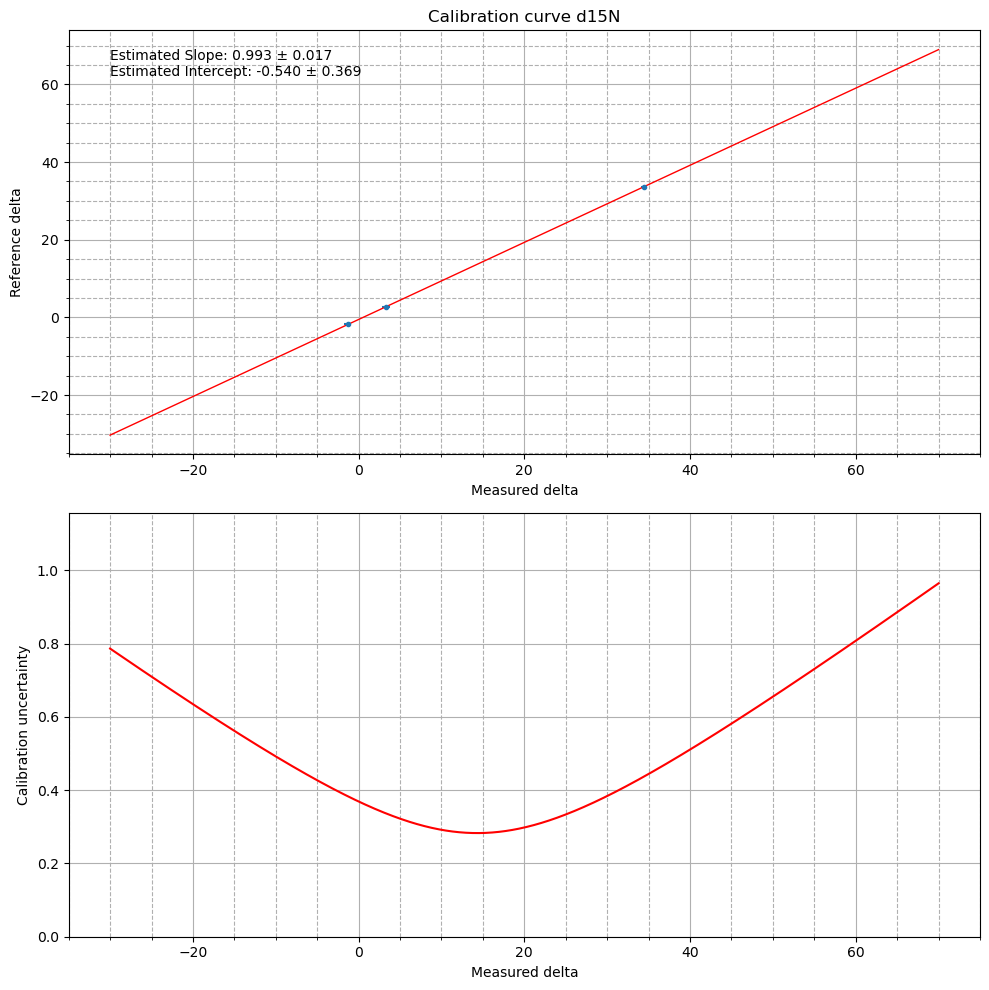

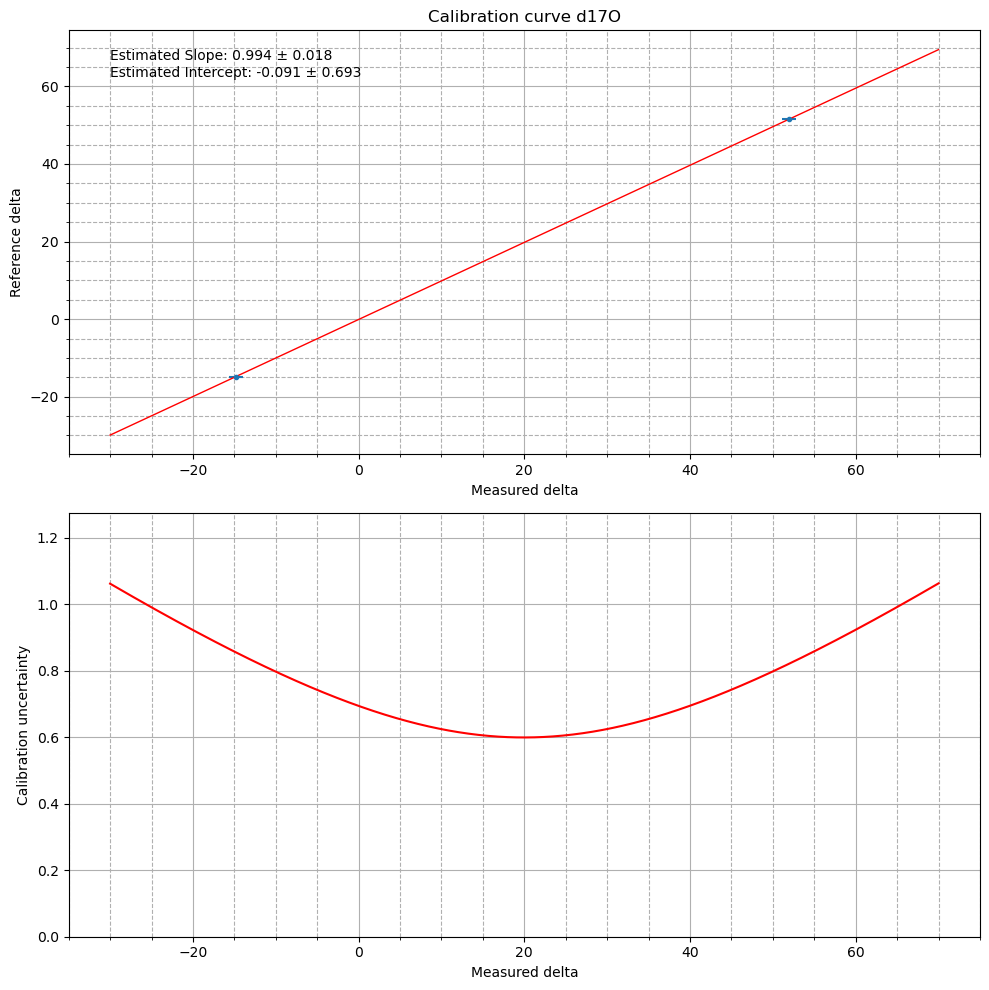

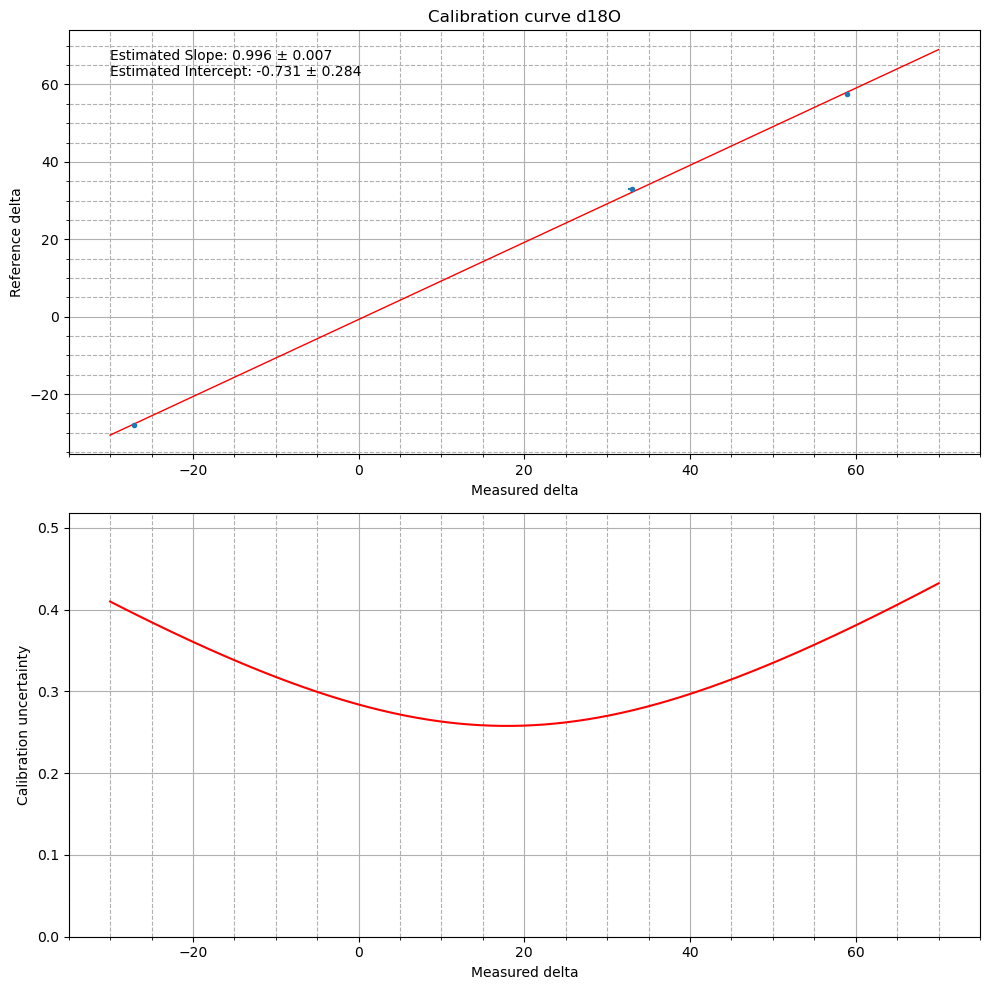

In [137]:
# Linear calibration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime
current_datetime = datetime.now()
current_date_string = current_datetime.strftime("%Y-%m-%d")

# Number of iterations for perturbation
num_iterations = 1000
#  delta points to calculate calibration at
n_points = 1000
delta_range = [-30,70]
delta_meas=np.linspace(delta_range[0],delta_range[1],n_points)


# Create a DF with calibrations for all isotopes
isotopelist=['15N','17O','18O']
calibrations = pd.DataFrame(columns=['delta_meas','d15N_true','d17O_true','d18O_true','d15N_err','d17O_err','d18O_err'],index=range(n_points))
calibrations['delta_meas'] = delta_meas

for isotope in isotopelist:

    xx = stds_stats.reset_index()['mean_d'+isotope][refs_stats.reset_index()['mean_d'+isotope].notna()]
    dx = stds_stats.reset_index()['err_d'+isotope][refs_stats.reset_index()['mean_d'+isotope].notna()]
    yy= refs_stats.reset_index()['mean_d'+isotope][refs_stats.reset_index()['mean_d'+isotope].notna()]
    dy = refs_stats.reset_index()['err_d'+isotope][refs_stats.reset_index()['mean_d'+isotope].notna()]

    # Lists to store the results of each iteration
    slope_values = []
    intercept_values = []
    calib_values = np.zeros([n_points, num_iterations])

#   Peturb deltas by their uncertainty 
    for n in range(num_iterations):
        # Perturb x and y based on their Gaussian uncertainties
        perturbed_y = np.random.normal(yy, dy)
        perturbed_x = np.random.normal(xx, dx)

        # Perform linear regression on the perturbed data
        model = LinearRegression()
        model.fit(perturbed_x.reshape(-1, 1), perturbed_y)

        # Get the slope and intercept of the regression line for the perturbed data
        slope_values.append(model.coef_[0])
        intercept_values.append(model.intercept_)

        calib_values[:,n] = model.predict(delta_meas.reshape(-1, 1))

    # Calculate and save calibration stats
    calib_values = pd.DataFrame(calib_values)
    delta_true_mean = calib_values.mean(axis=1)
    delta_true_err = calib_values.std(axis=1)
    calibrations['d'+isotope+'_true'] = delta_true_mean
    calibrations['d'+isotope+'_err'] = delta_true_err
    

    # Calculate the mean and standard deviation of the obtained slope and intercept values
    mean_slope = np.mean(slope_values)
    std_slope = np.std(slope_values)
    mean_intercept = np.mean(intercept_values)
    std_intercept = np.std(intercept_values)

    # Plot the calibration curve and distribution of slope and intercept values
    plt.figure(figsize=(10,10))

    plt.subplot(2,1,1)
    plt.errorbar(xx,yy,
                 xerr=dx, yerr=dy,
                 fmt='.', label='Data Points')
    plt.plot(delta_meas, delta_true_mean, color='red', label='Weighted Linear Regression',lw=1)
    plt.xlabel('Measured delta')
    plt.ylabel('Reference delta')
    plt.title('Calibration curve d'+isotope)
    plt.text(np.min(delta_meas),0.9*np.max(delta_true_mean), f"Estimated Slope: {mean_slope:.3f} ± {std_slope:.3f}\nEstimated Intercept: {mean_intercept:.3f} ± {std_intercept:.3f}")
    plt.gca().yaxis.set_minor_locator(MultipleLocator(5))
    plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
    plt.grid()
    plt.grid(which='minor',linestyle='--')

    plt.subplot(2,1,2)
    plt.plot(delta_meas, delta_true_err, color='red', label='Uncertainty')
    plt.xlabel('Measured delta')
    plt.ylabel('Calibration uncertainty')
    plt.ylim([0,1.2*np.max(delta_true_err)])
    plt.gca().xaxis.set_minor_locator(MultipleLocator(5))
    plt.grid()
    plt.grid(which='minor',linestyle='--')

    plt.tight_layout()

    plt.gcf().savefig(os.path.join(folder,'calibration','_'.join(['calibration_curve',isotope,current_date_string,'.png'])));
    
# EXPORT
calibrations.to_csv(os.path.join(folder,'calibration',''.join(['calibration_',current_date_string,'.csv'])))

    
    

### Apply calibration to samples

In [107]:
#  CORRECTION of deltas using calibration

samples_corrected = samples_stats

for isotope in isotopelist:
    
    delta_corrected = np.interp(samples_stats['mean_d'+isotope],calibrations['delta_meas'],calibrations['d'+isotope+'_true'])
    calib_err = np.interp(samples_stats['mean_d'+isotope],calibrations['delta_meas'],calibrations['d'+isotope+'_err'])
    err_corrected = np.sqrt( samples_stats['err_d'+isotope]**2 + calib_err**2)
    
    samples_corrected['mean_d'+isotope] = delta_corrected
    samples_corrected['err_d'+isotope]=err_corrected
    
# EXPORT
samples_corrected.to_csv(os.path.join(folder,''.join(['calibrated_results_',current_date_string,'.csv'])))

samples_corrected

,sample.name,mean_d15N,mean_d17O,mean_d18O,err_d15N,err_d17O,err_d18O
0,CDD-202,-2.794588,61.171309,68.035042,0.718030,1.606043,0.607798
1,CDD-203,-3.132357,53.195109,60.461509,0.802713,1.444422,0.661385
2,CDD-204,-2.779233,49.971136,57.709630,0.738420,1.738567,0.543652
3,CDD-205,-2.568867,57.712666,65.373934,0.660367,1.762761,0.653202
4,CDD-206,0.012993,63.410565,68.035042,0.622619,1.481636,0.617672
5,CDD-207,-3.517475,61.225764,68.035042,0.923869,1.512802,0.652802
6,CDD-208,-3.630848,60.971113,68.035042,0.829164,1.433629,0.683329
7,CDD-209,-1.484443,43.629904,53.912549,0.784114,1.380416,0.619393


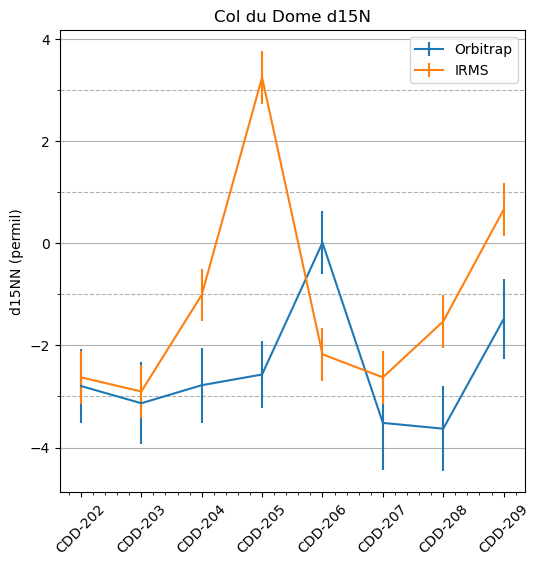

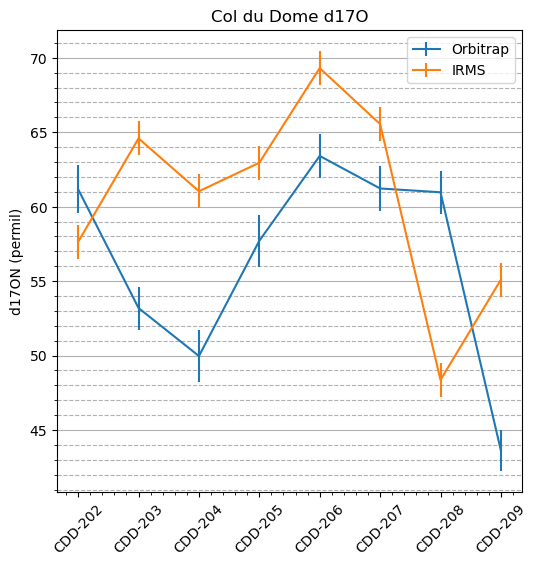

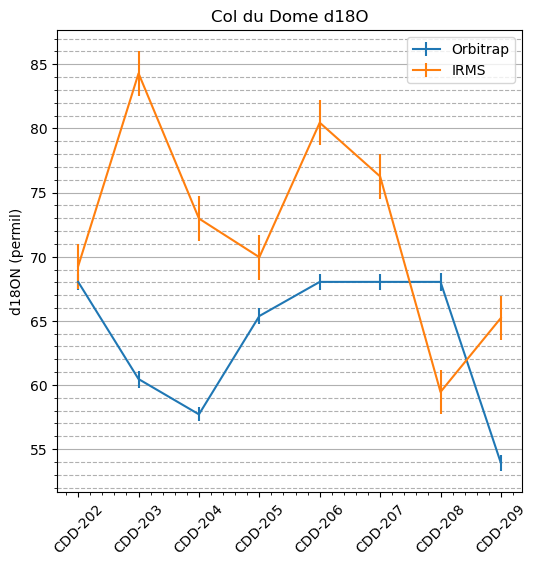

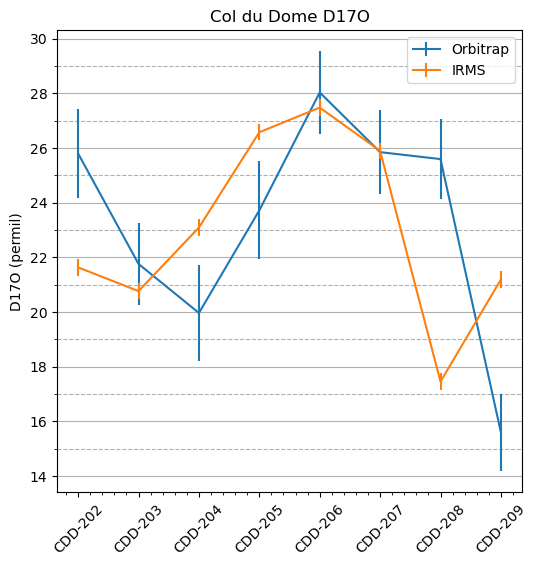

In [118]:
IRMS = pd.read_excel('CDD-IRMS.xlsx').iloc[17:25].reset_index(drop=True)

IRMS['sample.name']=samples_corrected['sample.name']

isotopes = ['15N','17O','18O']

for isotope in isotopes:
    
    plt.figure(figsize=[6,6])
    plt.errorbar(samples_corrected['sample.name'],samples_corrected['mean_d'+isotope],yerr=samples_corrected['err_d'+isotope],label='Orbitrap')
    plt.errorbar(IRMS['sample.name'],IRMS['d'+isotope+'_IRMS'],yerr=IRMS['d'+isotope+'_err'],label='IRMS')

    plt.ylabel('d'+isotope+'N (permil)')
    plt.xticks(rotation=45);
    plt.title('Col du Dome d'+isotope)
    plt.legend()
    # Set a minor tick spacing of 1 on the y-axis
    plt.minorticks_on()
    plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(axis='y')
    plt.grid(axis='y', which='minor',linestyle='--')

D17O_orbitrap = samples_corrected['mean_d17O']-0.52*samples_corrected['mean_d18O']
D17O_orbitrap_err = np.sqrt( samples_corrected['err_d17O']**2 + (0.52 * samples_corrected['err_d18O'])**2 )
D17O_IRMS = IRMS['d17O_IRMS']-0.52*IRMS['d18O_IRMS']
D17O_IRMS_err = 0.3

plt.figure(figsize=[6,6])
plt.errorbar(samples_corrected['sample.name'],D17O_orbitrap,yerr=D17O_orbitrap_err,label='Orbitrap')
plt.errorbar(IRMS['sample.name'],D17O_IRMS,yerr=D17O_IRMS_err,label='IRMS')

plt.ylabel('D17O (permil)')
plt.xticks(rotation=45);
plt.title('Col du Dome D17O')
plt.legend()
# Set a minor tick spacing of 1 on the y-axis
plt.minorticks_on()
plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
plt.grid(axis='y')
plt.grid(axis='y', which='minor',linestyle='--')

In [119]:
IRMS

,sample.name,d15N_IRMS,d17O_IRMS,d18O_IRMS,d15N_err,d17O_err,d18O_err
0,CDD-202,-2.624140,57.641891,69.255325,0.517259,1.147,1.7436
1,CDD-203,-2.902007,64.592359,84.288660,0.517259,1.147,1.7436
2,CDD-204,-1.010590,61.036767,72.974624,0.517259,1.147,1.7436
3,CDD-205,3.251317,62.955284,69.960642,0.517259,1.147,1.7436
4,CDD-206,-2.173005,69.310950,80.447338,0.517259,1.147,1.7436
5,CDD-207,-2.625136,65.546586,76.254867,0.517259,1.147,1.7436
6,CDD-208,-1.527685,48.364407,59.453110,0.517259,1.147,1.7436
7,CDD-209,0.661722,55.100834,65.222597,0.517259,1.147,1.7436
